<a href="https://colab.research.google.com/github/glet2024/CLPS-1291-FP/blob/main/NEW_Comp_Methods_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Methods: Final Project
Joyce Gao, Gus LeTourneau, Tao Burga

In [ ]:
# maybe important imports, most probably not!
import os
import cv2
import sys
import glob
import numpy as np
import torch
from torchsummary import summary
from torchvision import transforms
import random
import requests
import pandas as pd
from PIL import Image
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
from google.colab.patches import cv2_imshow

In [ ]:
# Make sure we are using the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on GPU!" if "cuda" in str(device) else "Change Runtime Type to GPU.")

Running on GPU!


In [ ]:
%config InlineBackend.figure_format='retina'

In [ ]:
import torch
model, transforms = torch.hub.load('harvard-visionlab/lrm-steering', 'alexnet_lrm3', pretrained=True, steering=True, force_reload=True)
model


/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/harvard-visionlab/lrm-steering/zipball/main" to /root/.cache/torch/hub/main.zip


==> Loading weights for alexnet_lrm3, hash_id=63ab1b3b06
https://s3.us-east-1.wasabisys.com/visionlab-projects/dnn_feedback_dev/logs/set15/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps/28453e80-c5e5-4d76-bc81-99c5fade39ff/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps_final_weights-63ab1b3b06.pth


Downloading: "https://s3.us-east-1.wasabisys.com/visionlab-projects/dnn_feedback_dev/logs/set15/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps/28453e80-c5e5-4d76-bc81-99c5fade39ff/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps_final_weights-63ab1b3b06.pth" to /root/.cache/torch/hub/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps_final_weights-63ab1b3b06.pth
100%|██████████| 249M/249M [00:06<00:00, 40.3MB/s]


local_filename: /root/.cache/torch/hub/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps_final_weights-63ab1b3b06.pth
<All keys matched successfully>


SteerableLRM(
  (feedforward): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False

CORnet-RT Model download and load:

In [ ]:
# download the CORnet-RT pytorch model:
!wget https://s3.amazonaws.com/cornet-models/cornet_rt-933c001c.pth

path = 'cornet_rt-933c001c.pth'

# load model:
cornet_model = torch.load(path, map_location=device)
#print(cornet_model)
print(cornet_model['state_dict'].keys())

--2023-12-05 19:03:08--  https://s3.amazonaws.com/cornet-models/cornet_rt-933c001c.pth
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.197.224, 16.182.108.8, 16.182.36.232, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.197.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41683032 (40M) [application/x-www-form-urlencoded]
Saving to: ‘cornet_rt-933c001c.pth’

cornet_rt-933c001c. 100%[===================>]  39.75M  25.2MB/s    in 1.6s    

2023-12-05 19:03:10 (25.2 MB/s) - ‘cornet_rt-933c001c.pth’ saved [41683032/41683032]

odict_keys(['module.V1.conv_input.weight', 'module.V1.conv_input.bias', 'module.V1.norm_input.weight', 'module.V1.norm_input.bias', 'module.V1.conv1.weight', 'module.V1.norm1.weight', 'module.V1.norm1.bias', 'module.V2.conv_input.weight', 'module.V2.conv_input.bias', 'module.V2.norm_input.weight', 'module.V2.norm_input.bias', 'module.V2.conv1.weight', 'module.V2.norm1.weight', 'module.V2.norm1.bias', 'module.V4.conv_i

In [ ]:
from collections import OrderedDict
import torch
from torch import nn


HASH = '933c001c'


class Flatten(nn.Module):

    """
    Helper module for flattening input tensor to 1-D for the use in Linear modules
    """

    def forward(self, x):
        return x.view(x.size(0), -1)


class Identity(nn.Module):

    """
    Helper module that stores the current tensor. Useful for accessing by name
    """

    def forward(self, x):
        return x


class CORblock_RT(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, out_shape=None):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.out_shape = out_shape

        self.conv_input = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                                    stride=stride, padding=kernel_size // 2)
        self.norm_input = nn.GroupNorm(32, out_channels)
        self.nonlin_input = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1, bias=False)
        self.norm1 = nn.GroupNorm(32, out_channels)
        self.nonlin1 = nn.ReLU(inplace=True)

        self.output = Identity()  # for an easy access to this block's output

    def forward(self, inp=None, state=None, batch_size=None):
        if inp is None:  # at t=0, there is no input yet except to V1
            inp = torch.zeros([batch_size, self.out_channels, self.out_shape, self.out_shape])
            if self.conv_input.weight.is_cuda:
                inp = inp.cuda()
        else:
            inp = self.conv_input(inp)
            inp = self.norm_input(inp)
            inp = self.nonlin_input(inp)

        if state is None:  # at t=0, state is initialized to 0
            state = 0
        skip = inp + state

        x = self.conv1(skip)
        x = self.norm1(x)
        x = self.nonlin1(x)

        state = self.output(x)
        output = state
        return output, state


class CORnet_RT(nn.Module):

    def __init__(self, times=5):
        super().__init__()
        self.times = times

        self.V1 = CORblock_RT(3, 64, kernel_size=7, stride=4, out_shape=56)
        self.V2 = CORblock_RT(64, 128, stride=2, out_shape=28)
        self.V4 = CORblock_RT(128, 256, stride=2, out_shape=14)
        self.IT = CORblock_RT(256, 512, stride=2, out_shape=7)
        self.decoder = nn.Sequential(OrderedDict([
            ('avgpool', nn.AdaptiveAvgPool2d(1)),
            ('flatten', Flatten()),
            ('linear', nn.Linear(512, 1000))
        ]))

    def forward(self, inp):
        outputs = {'inp': inp}
        states = {}
        blocks = ['inp', 'V1', 'V2', 'V4', 'IT']

        for block in blocks[1:]:
            if block == 'V1':  # at t=0 input to V1 is the image
                this_inp = outputs['inp']
            else:  # at t=0 there is no input yet to V2 and up
                this_inp = None
            new_output, new_state = getattr(self, block)(this_inp, batch_size=len(outputs['inp']))
            outputs[block] = new_output
            states[block] = new_state

        for t in range(1, self.times):
            new_outputs = {'inp': inp}
            for block in blocks[1:]:
                prev_block = blocks[blocks.index(block) - 1]
                prev_output = outputs[prev_block]
                prev_state = states[block]
                new_output, new_state = getattr(self, block)(prev_output, prev_state)
                new_outputs[block] = new_output
                states[block] = new_state
            outputs = new_outputs

        out = self.decoder(outputs['IT'])
        return out

In [ ]:
# Note: (Tao) getting the error message "AttributeError: 'dict' object has no attribute 'Compose'"
# So importing this again:
from torchvision import transforms

In [ ]:
# Load the model dictionary
model_dict = torch.load('cornet_rt-933c001c.pth', map_location=device)

print(model_dict.keys())

state_dict = model_dict['state_dict']
print(state_dict)

model = CORnet_RT()
state_dict = {key.replace('module.', ''): value for key, value in state_dict.items()}
model.load_state_dict(state_dict)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



dict_keys(['flags', 'epoch', 'state_dict', 'optimizer'])
OrderedDict([('module.V1.conv_input.weight', tensor([[[[ 1.0640e-02,  3.0362e-03, -1.3386e-05,  ..., -2.9929e-02,
           -1.4227e-02, -1.5468e-02],
          [ 3.2235e-02,  3.3044e-02,  2.6024e-02,  ..., -9.4452e-03,
            3.7706e-03,  5.6001e-03],
          [ 5.0684e-02,  5.2331e-02,  5.2154e-02,  ...,  4.6163e-02,
            5.3684e-02,  3.7807e-02],
          ...,
          [ 2.1885e-02,  4.4660e-03, -3.5361e-02,  ..., -6.5391e-02,
           -1.2442e-02, -1.1244e-02],
          [ 5.5228e-02,  3.4212e-02, -1.7575e-02,  ..., -6.1097e-02,
           -3.2051e-03,  1.4607e-02],
          [ 5.6555e-02,  3.3053e-02,  1.2818e-02,  ...,  2.0944e-03,
            3.7695e-02,  5.0104e-02]],

         [[-2.4367e-02, -3.2623e-02, -3.2837e-02,  ..., -6.5562e-02,
           -3.3999e-02, -2.4648e-02],
          [-2.0514e-02, -2.1336e-02, -2.5081e-02,  ..., -6.1100e-02,
           -3.4405e-02, -2.0762e-02],
          [-1.3607e-02, -

In [ ]:
!wget https://danielrosengren.se/wp-content/uploads/2019/12/DTR0813_Brown-Bear_square.jpg

image_path = 'DTR0813_Brown-Bear_square.jpg'
image = Image.open(image_path).convert("RGB")
input_data = transform(image)
input_data = input_data.unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    model.eval()
    output = model(input_data)
    output = nn.functional.softmax(output, dim=1) #use softmax to convert to probabilities

# print(output)

--2023-12-05 19:03:16--  https://danielrosengren.se/wp-content/uploads/2019/12/DTR0813_Brown-Bear_square.jpg
Resolving danielrosengren.se (danielrosengren.se)... 172.67.200.240, 104.21.21.228, 2606:4700:3032::ac43:c8f0, ...
Connecting to danielrosengren.se (danielrosengren.se)|172.67.200.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333917 (326K) [image/jpeg]
Saving to: ‘DTR0813_Brown-Bear_square.jpg’

DTR0813_Brown-Bear_ 100%[===================>] 326.09K  --.-KB/s    in 0.01s   

2023-12-05 19:03:16 (23.0 MB/s) - ‘DTR0813_Brown-Bear_square.jpg’ saved [333917/333917]



In [ ]:
import json
import urllib.request
import numpy as np

# Download the ImageNet class labels JSON file
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
response = urllib.request.urlopen(url)
data = json.load(response)

# Extract class labels and descriptions
imagenet_classes = [value[1] for key, value in sorted(data.items(), key=lambda x: int(x[0]))]

# Convert to NumPy array for easy indexing
imagenet_classes_array = np.array(imagenet_classes)

In [ ]:
predicted_class_index = torch.argmax(output, dim=1).item()

# Print or use the predicted class index
print("Predicted Class Index:", predicted_class_index)
print(output[0][294])
print(imagenet_classes_array[predicted_class_index])

Predicted Class Index: 294
tensor(0.9713)
brown_bear


In [ ]:
# add decode_preds function for easier prediction? - Joyce

import json
import urllib.request
import numpy as np

# Download the ImageNet class labels JSON file
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
response = urllib.request.urlopen(url)
data = json.load(response)

# Extract class labels and descriptions
imagenet_classes = [value[1] for key, value in sorted(data.items(), key=lambda x: int(x[0]))]

# Convert to NumPy array for easy indexing
imagenet_classes_array = np.array(imagenet_classes)

# decode the prediction output from the model
def decode_preds(model_output, class_names=imagenet_classes_array):
  model_output = nn.functional.softmax(model_output, dim=1)
  predicted_class_index = torch.argmax(model_output, dim=1).item()

  label = imagenet_classes_array[predicted_class_index]
  score = output[0][294].cpu().numpy()

  print(f'\nClass: {label}, Probability: {score}')
  return label

# perform inference and decode prediction
with torch.no_grad():
  model.eval()
  output_vector = model(input_data)
decode_preds(output_vector)


Class: brown_bear, Probability: 0.9713049530982971


'brown_bear'

# Making attribution maps

In [ ]:
!pip install torchvision==0.13.0
!pip install git+https://github.com/pytorch/captum.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu118
    Uninstalling torchvision-0.16.0+cu118:
      Successfully uninstalled torchvision-0.16.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.


  Cloning https://github.com/pytorch/captum.git to /tmp/pip-req-build-nlwe7_hn
  Running command git clone --filter=blob:none --quiet https://github.com/pytorch/captum.git /tmp/pip-req-build-nlwe7_hn
  Resolved https://github.com/pytorch/captum.git to commit 68d88cf6bec6a0bf73575d2d7be1b2506fdce61c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for captum: filename=captum-0.7.0-py3-none-any.whl size=637238 sha256=7faa00118b20eef4b8b20eb6c02e7fffb10d5b40d5ea8f9d17c4b7723d423e61
  Stored in directory: /tmp/pip-ephem-wheel-cache-vsw7e0h_/wheels/8e/b7/c3/e17a61e561b99ab720ae04e56543dcd69884dee09a09bf5ae4
Successfully built captum


In [ ]:
import matplotlib.pyplot as plt
import captum
from captum.attr import visualization as viz
from captum.attr import Saliency

In [ ]:
# Define the preprocessing pipeline for the input image
preprocess = transforms.Compose([
    transforms.Resize((256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img_tensor = preprocess(img)
    img_tensor.unsqueeze_(0)  # Add a batch dimension
    return img_tensor

def make_saliency_map(image_path):
  resized_image = load_and_preprocess_image(image_path).to(device)
  attribution = saliency.attribute(resized_image, target = 0)

  # The preprocessing included normalizing the image which we need invert here
  inv_normalize = transforms.Normalize(
      mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
      std=[1/0.229, 1/0.224, 1/0.255]
  )

  unnorm_image = inv_normalize(resized_image)

  # Display the image and the attribution
  _ = viz.visualize_image_attr_multiple(np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0)),
                                        np.transpose(unnorm_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                        ["original_image", "heat_map"],
                                        ["all", "absolute_value"],
                                        cmap=None,
                                        show_colorbar=True, outlier_perc=2)

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


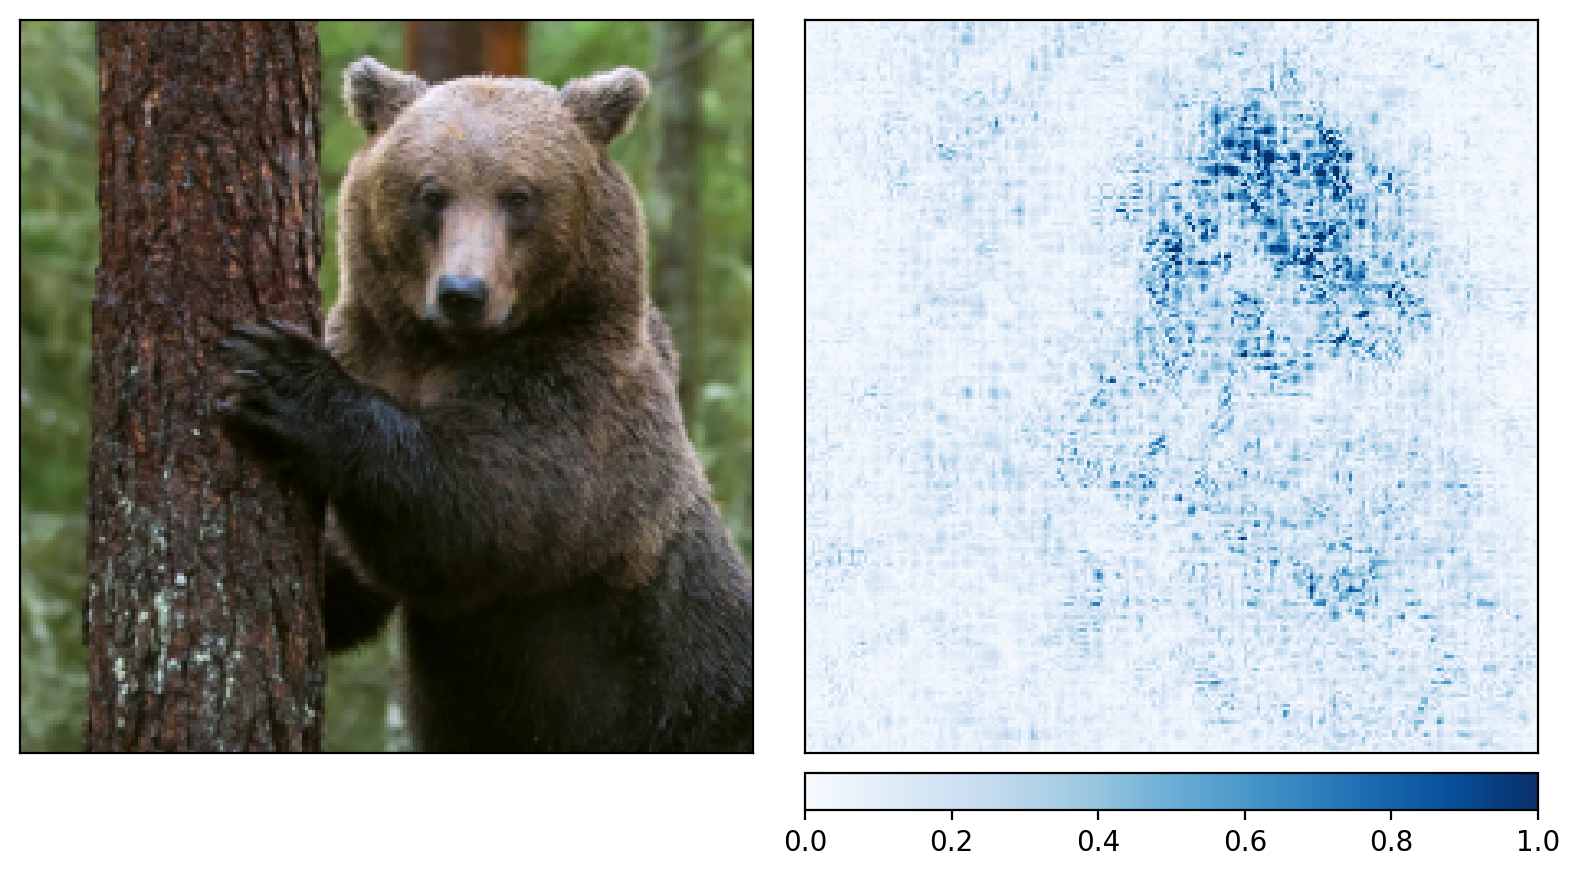

In [ ]:
saliency = Saliency(model.cuda())
make_saliency_map('/content/DTR0813_Brown-Bear_square.jpg')

# Getting Human saliency maps
From the ClickMe dataset

In [ ]:
# Getting and unzipping all the ClickMe training data (too large)
#!wget --no-check-certificate https://connectomics.clps.brown.edu/tf_records/clicktionary_files/clickme_train.zip
#!unzip clickme_train.zip

In [ ]:
# Loading 2 standalone npz files from ClickMe validation dataset
!wget --no-check-certificate https://connectomics.clps.brown.edu/tf_records/clicktionary_files/clickme_val/0.npz
!wget --no-check-certificate https://connectomics.clps.brown.edu/tf_records/clicktionary_files/clickme_val/1.npz


--2023-12-05 19:05:17--  https://connectomics.clps.brown.edu/tf_records/clicktionary_files/clickme_val/0.npz
Resolving connectomics.clps.brown.edu (connectomics.clps.brown.edu)... 128.148.254.120
Connecting to connectomics.clps.brown.edu (connectomics.clps.brown.edu)|128.148.254.120|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1049588 (1.0M) [application/octet-stream]
Saving to: ‘0.npz’

0.npz               100%[===================>]   1.00M  1.83MB/s    in 0.5s    

2023-12-05 19:05:18 (1.83 MB/s) - ‘0.npz’ saved [1049588/1049588]

--2023-12-05 19:05:18--  https://connectomics.clps.brown.edu/tf_records/clicktionary_files/clickme_val/1.npz
Resolving connectomics.clps.brown.edu (connectomics.clps.brown.edu)... 128.148.254.120
Connecting to connectomics.clps.brown.edu (connectomics.clps.brown.edu)|128.148.254.120|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting

In [ ]:
# Loading a single npz file from ClickMe validation dataset

# Load the .npz file
npz_data = np.load('0.npz')

# invividual files within the npz file:
print(npz_data.files)

# separately save image and heatmap
image = npz_data['image']
heatmap = npz_data['heatmap']

['image', 'heatmap', 'clicks', 'label']


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from captum.attr import Saliency
from captum.attr import visualization as viz

# function now accepts a numpy array instead of image path, also normalizes
def preprocess_image_array(image_np):
    # normalize to [0, 1] if not already normalized
    if image_np.max() > 1.0:
      image_np = image_np / 255.0
    img = Image.fromarray((image_np * 255).astype(np.uint8))
    img_tensor = preprocess(img)
    img_tensor.unsqueeze_(0)  # Add a batch dimension
    return img_tensor

# modified saliency map function to take
def make_saliency_map(image_np, heatmap_np):

    # preprocess image array and conver to tensor
    preprocessed_image = preprocess_image_array(image_np).to(device)

    # initialize saliency object
    saliency = Saliency(model)

    # generate saliency map
    attribution = saliency.attribute(preprocessed_image, target=0)
    heatmap_crnn = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1, 2, 0))

    # invert image normalization
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )

    # invert image normalization to display image
    unnorm_image = inv_normalize(preprocessed_image)

    # display image and attribution map
    _ = viz.visualize_image_attr_multiple(np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(unnorm_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "heat_map"],
                                          ["all", "absolute_value"],
                                          cmap=None,
                                          show_colorbar=True, outlier_perc=2)


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


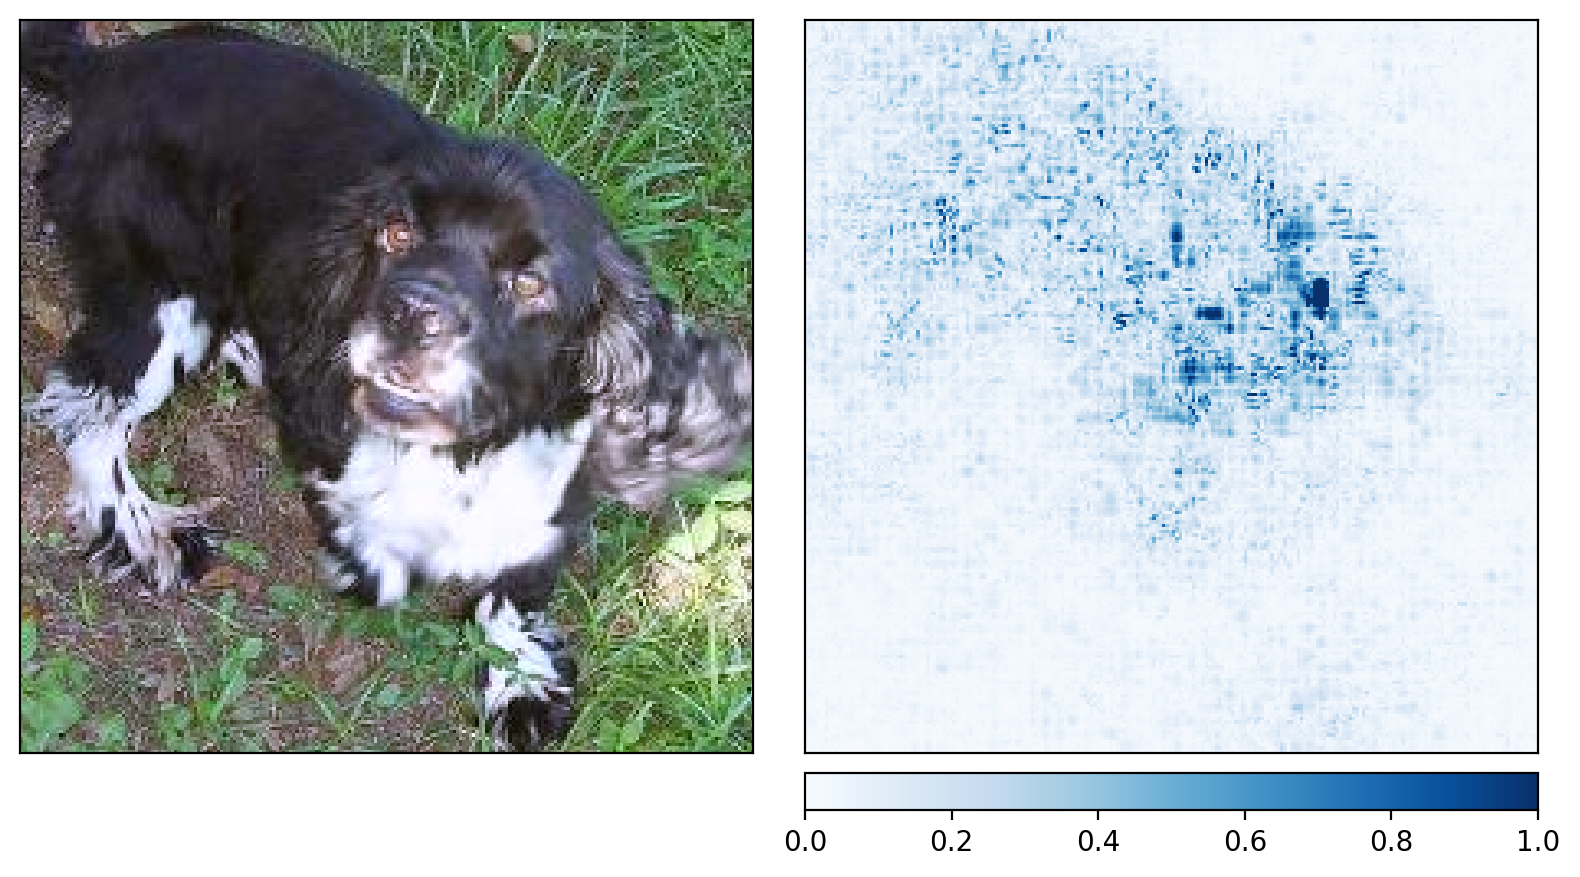

In [ ]:
# Display original ClickMe image and CRNN saliency map
make_saliency_map(image, heatmap)

In [ ]:
# creating a function to display the original ClickMe image and human heatmap
def human_image_heatmap(image_np, heatmap_np):
    plt.figure(figsize=(10, 5))

    # Normalize the image data to [0, 1] if it's not already
    if image_np.dtype == np.float32:
        # Check if normalization is needed
        if image_np.min() < 0 or image_np.max() > 1:
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    # Subplot for the image
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')

    # Subplot for the heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap_np, cmap='hot', interpolation='nearest')
    plt.title('Heatmap')
    plt.axis('off')

    plt.show()

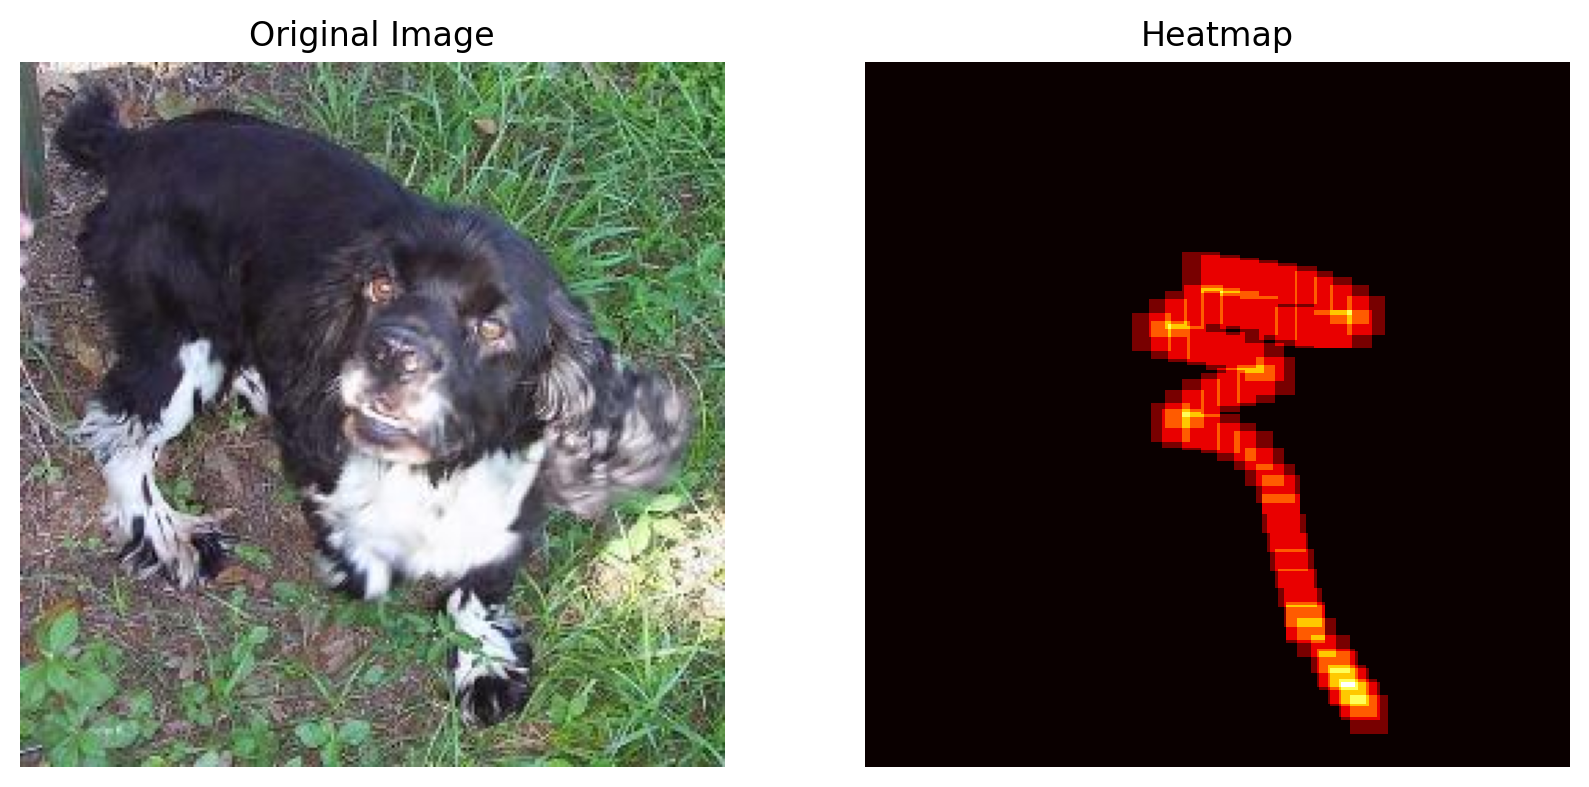

In [ ]:
human_image_heatmap(image, heatmap)

In [ ]:
heatmap

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
heatmap_crnn

NameError: ignored